In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Fixed trigger

Use an exponential decay in time, and Gaussian in space, and see what background we can fit to the Chicago data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_fixed
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.naive
import sepp.sepp_full
import sepp.kernels
import opencrimedata.chicago

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

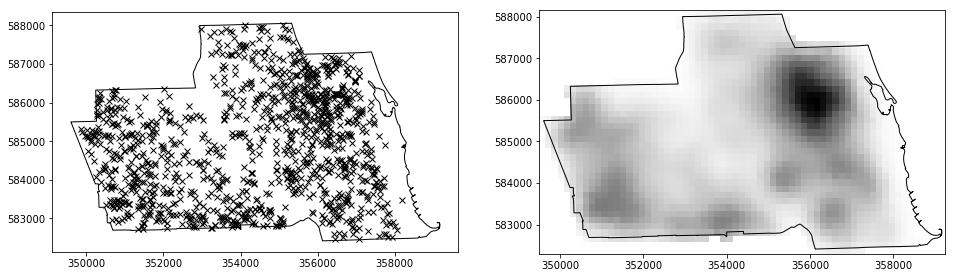

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

# Train

In [7]:
tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
bkp = sepp.kernels.FixedBandwidthKernelProvider(50)
trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
trainer.data = points
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

KDEModel(T=730.9583333333334, mu=1.5705687298573139, background=<open_cp.kernels.GaussianBase object at 0x000001DE91660828>, theta=0.06740836623724422, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50)

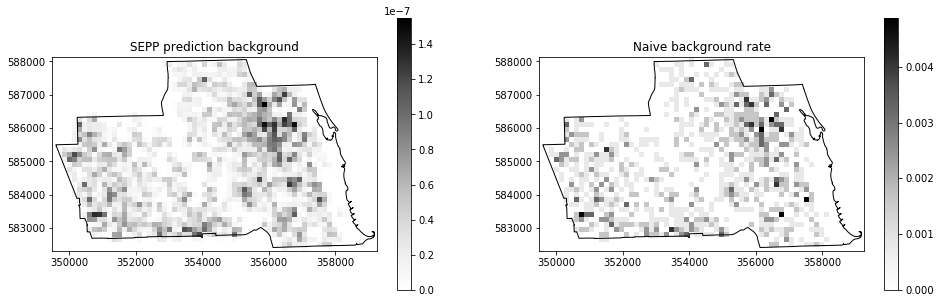

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

for ax in axes:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

ax = axes[0]
pred = open_cp.predictors.KernelRiskPredictor(model.background_kernel)
pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)
ax.set_title("SEPP prediction background")

naive = open_cp.naive.CountingGridKernel(grid.xsize, grid.ysize, grid.region())
naive.data = points
pred = naive.predict().renormalise()
ax = axes[1]
m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
cb = fig.colorbar(m, ax=ax)
ax.set_title("Naive background rate")

None

### Speed of convergence

In [9]:
trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
for _ in range(30):
    opt = trainer._optimiser(model, data)
    old_model = model
    model = opt.iterate()
    print(model, np.mean((model.mu - old_model.mu)**2), (model.theta - old_model.theta)**2)

KDEModel(T=730.9583333333334, mu=1.3644970323603025, background=<open_cp.kernels.GaussianBase object at 0x000001DE91678A20>, theta=0.1897721554733008, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.10213999762 0.0962413155197
KDEModel(T=730.9583333333334, mu=1.4901760698082298, background=<open_cp.kernels.GaussianBase object at 0x000001DE8DEE5128>, theta=0.11514490953676654, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.0157952204538 0.00556922583607
KDEModel(T=730.9583333333334, mu=1.5310215120120818, background=<open_cp.kernels.GaussianBase object at 0x000001DE8DEE5518>, theta=0.09089120006674926, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.00166835014883 0.000588242423056
KDEModel(T=730.9583333333334, mu=1.548712156224637, background=<open_cp.kernels.GaussianBase object at 0x000001DE917D1908>, theta=0.08038663157836394, f=ExpTimeKernel(omega=0.2), g=GaussianSpaceKernel(sigma=50) 0.000312958892655 0.000110345959127
KDEModel(T=730.95833

## Dependence on parameters

In [10]:
bandwidths = np.linspace(20,300,50)
models = dict()
for bw in bandwidths:
    tk = sepp.sepp_fixed.ExpTimeKernel(0.2)
    sk = sepp.sepp_fixed.GaussianSpaceKernel(50)
    bkp = sepp.kernels.FixedBandwidthKernelProvider(bw)
    trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
    trainer.data = points
    models[bw] = trainer.train(datetime.datetime(2018,1,1), iterations=20)

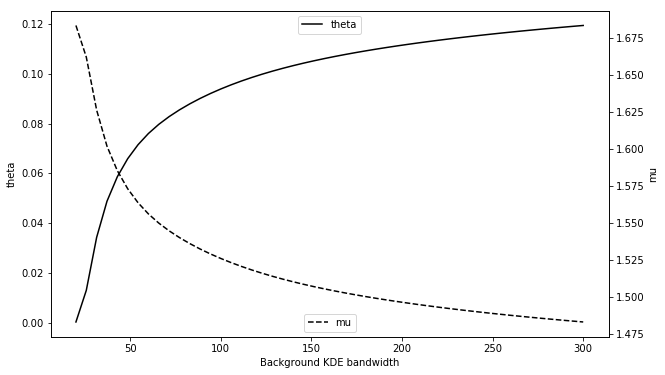

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bandwidths, [models[bw].theta for bw in bandwidths], label="theta", color="black", linestyle="-")
ax.set(ylabel="theta", xlabel="Background KDE bandwidth")
ax.legend(loc="upper center")
ax1 = ax.twinx()
ax1.plot(bandwidths, [models[bw].mu for bw in bandwidths], label="mu", color="black", linestyle="--")
ax1.set(ylabel="mu")
ax1.legend(loc="lower center")
None

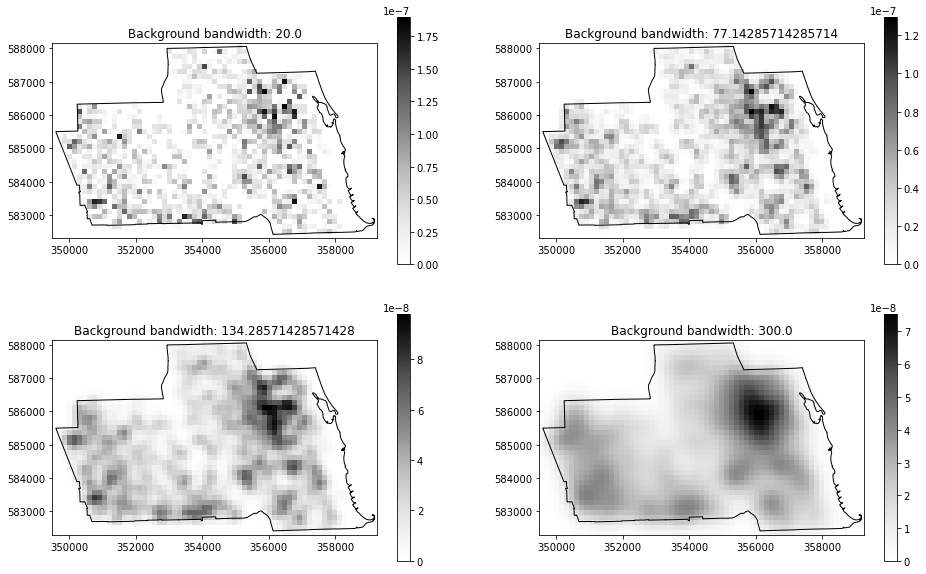

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

for ax, i in zip(axes.flat, [0,10,20,-1]):
    bw = bandwidths[i]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    pred = open_cp.predictors.KernelRiskPredictor(models[bw].background_kernel, samples=-5)
    pred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(pred, grid)
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)
    ax.set_title("Background bandwidth: {}".format(bw))

# Varying parameters

In [14]:
all_models = []
for sigma, maxoi in zip([10, 25, 50, 100, 250], [500,500,500,100,100]):
    omegas_inv = np.linspace(1, maxoi, 30)
    models = {}
    for omega_inv in omegas_inv:
        for bkb in [20, 50, 100, 200]:
            tk = sepp.sepp_fixed.ExpTimeKernel(1 / omega_inv)
            sk = sepp.sepp_fixed.GaussianSpaceKernel(sigma)
            bkp = sepp.kernels.FixedBandwidthKernelProvider(bkb)
            trainer = sepp.sepp_fixed.KDETrainer(tk, sk, bkp)
            trainer.data = points
            models[(omega_inv, bkb)] = trainer.train(datetime.datetime(2017,1,1), iterations=20)
    all_models.append((sigma, models))

p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has become diagonal-- no repeat behaviour!
p-matrix has

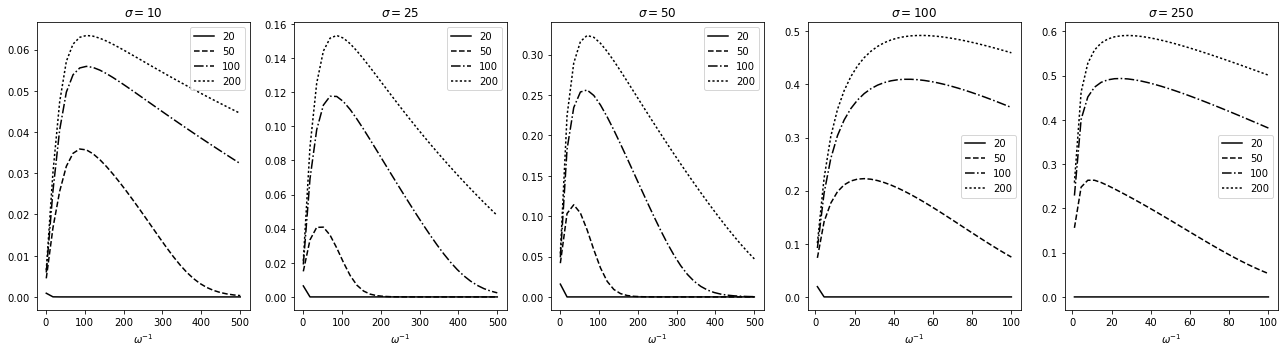

In [15]:
fig, axes = plt.subplots(ncols=5, figsize=(18,5))

for ax, (s, models) in zip(axes, all_models):
    ois = list(set(o for o,_ in models))
    ois.sort()
    bkbs = list(set(b for _, b in models))
    bkbs.sort()
    for b, ls in zip(bkbs, ["-", "--", "-.", ":"]):
        y = [models[(o,b)].theta for o in ois]
        ax.plot(ois, y, color="black", label=str(b), linestyle=ls)
    ax.set(xlabel="$\omega^{-1}$")
    ax.legend()
    #ax.set(ylabel="$\\theta$")
    ax.set(title="$\sigma={}$".format(s))
fig.tight_layout()

In [16]:
fig.savefig("../fixed_grid_mod_2.pdf")